In [43]:
from __future__ import division
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from scipy import signal
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from nilearn import image, plotting, masking
from nilearn.input_data import NiftiMasker
from nitime.timeseries import TimeSeries
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer
%matplotlib inline
plt.style.use('ggplot')

**Description of lag calculation from Siegel et al. 2015 (JCBFM)**

$$C_i(\tau) = (1/n_\tau)\sum \left[ \frac{g(t) \cdot s_i(t + \tau)}{\sigma_{s_i}\sigma_g}  \right]$$

* ***g*** is the gray matter signal
* ***s<sub>i</sub>*** is the signal in voxel ***i***
* ***σ<sub>s<sub>i</sub></sub>*** and  ***σ<sub>g</sub>*** are the standard deviations of the two signals

The summation runs over frames indexed by ***t***, and ***n<sub>τ</sub>***  is the number of frames included after a shift of ***τ***.

To determine the shift that maximizes the cross-correlation function at a temporal resolution finer than 1 TR, the lag (***τ***) corresponding to the maximum of ***C<sub>i</sub> (τ)*** is identified. ***C<sub>i</sub> (τ)*** at this lag, as well as one step forward and backward, is fit with a parabolic function and the peak value, ***C<sub>i</sub>  (τ<sup>m</sup>)*** and corresponding temporal shift ***(τ<sup>m</sup>)*** is computed. Positive and negative values of  ***τ<sup>m</sup>*** correspond, respectively, to a lag or lead relative to the mean gray matter signal.

In [2]:
def get_numerator(signal_a, signal_b, lag):
    """
    Calculates the numerator of the cross-correlation equation.
    
    Parameters
    ----------
    signal_a : array_like (1D)
        Reference signal.
    signal_b : array_like (1D)
        Test signal. Must be the same length as signal_a.
    lag : int
        Lag by which signal_b will be shifted relative to signal_a.
        
    Returns
    -------
    array_like (1D)
        Element-wise product of matching time points in the lagged signals.
    """ 
    if lag == 0:
        numerator = np.multiply(signal_a, signal_b)
    # If lag is positive, shift signal_b forwards relative to signal_a.
    if lag > 0:
        numerator = np.multiply(signal_a[lag:], signal_b[0:-lag])
    # If lag is negative, shift signal_b backward relative to signal_a.
    if lag < 0:
        numerator = np.multiply(signal_b[-lag:], signal_a[0:lag])
    return numerator

In [3]:
def get_denominator(signal_a, signal_b):
    """
    Calculates the denominator of the cross-correlation equation.
    
    Parameters
    ----------
    signal_a : array_like (1D)
        Reference signal.
    signal_b : array_like (1D)
        Test signal. Must be the same length as signal_a.
        
    Returns
    -------
    float
        Product of the standard deviations of the input signals.
    """ 
    denom = np.std(signal_a) * np.std(signal_b)
    if denom == 0:
        print("Denominator is zero!")
    return denom

In [4]:
def calc_xcorr(signal_a, signal_b, lag):
    """
    Calculate the cross-correlation of two signals at a given lag.
    
    Parameters
    ----------
    signal_a : array_like (1D)
        Reference signal.
    signal_b : array_like (1D)
        Test signal. Must be the same length as signal_a.
    lag : int
        Lag by which signal_b will be shifted relative to signal_a.
        
    Returns
    -------
    float
        Normalized cross-correlation.
    """ 
    
    xcorr = np.true_divide(1., len(signal_a)-np.absolute(lag)) * np.sum(np.true_divide(get_numerator(signal_a, signal_b, lag),
              get_denominator(signal_a, signal_b)))
    return xcorr

In [5]:
def sliding_xcorr(signal_a, signal_b, lags):
    """
    Calculate the cross-correlation of two signals over a range of lags.
    
    Parameters
    ----------
    signal_a : array_like (1D)
        Reference signal.
    signal_b : array_like (1D)
        Test signal. Must be the same length as signal_a.
    lags : array_like (1D)
        Lags by which signal_b will be shifted relative to signal_a.
        
    Returns
    -------
    array_like (1D)
        Normalized cross-correlation at each lag.
    """ 
    xcorr_vals = []
    for lag in lags:
        xcorr = calc_xcorr(signal_a, signal_b, lag)
        xcorr_vals.append(xcorr)
    return np.array(xcorr_vals)

In [6]:
# Adapted from https://gist.github.com/endolith/255291
def parabolic(sample_array, peak_index):
    """
    Quadratic interpolation for estimating the true position of an
    inter-sample local maximum when nearby samples are known.
   
    Parameters
    ----------
    sample_array : array_like (1D)
        Array of samples.
    peak_index : int
        Index for the local maximum in sample_array for which to estimate the inter-sample maximum.
   
    Returns
    -------
    tuple
        The (x,y) coordinates of the vertex of a parabola through peak_index and its two neighbors.
    """
    vertex_x = 1/2. * (sample_array[peak_index-1] - sample_array[peak_index+1]) / (sample_array[peak_index-1] - 2 * sample_array[peak_index] + sample_array[peak_index+1]) + peak_index
    vertex_y = sample_array[peak_index] - 1/4. * (sample_array[peak_index-1] - sample_array[peak_index+1]) * (vertex_x - peak_index)
    return (vertex_x, vertex_y)

In [7]:
def report_xcorr(xcorr_array, lags, interp=False):
    """
    Report the maximum value from a cross-correlation array.
    
    """
    lag_shift = np.sum(np.array(lags) > 0)
    if interp == True:
        max_xcorr = parabolic(xcorr_array, np.argmax(xcorr_array))[0] - lag_shift
    else:
        max_xcorr = np.argmax(xcorr_array) - lag_shift
    print("Maximum cross-correlation exists at a lag of {}.".format(max_xcorr))

### Test on dummy data

Two identical aperiodic time-series, with a lag difference of 3 frames.

In [8]:
simple_a = [0, 0, 0, 0, 0, 2, 2, 1, 2, 3, 2, 0, -1, -2, -2, 0, 0, 0, 0]
simple_b = [0, 0, 2, 2, 1, 2, 3, 2, 0, -1, -2, -2, 0, 0, 0, 0, 0, 0, 0]
simple_lags = range(-4, 5)

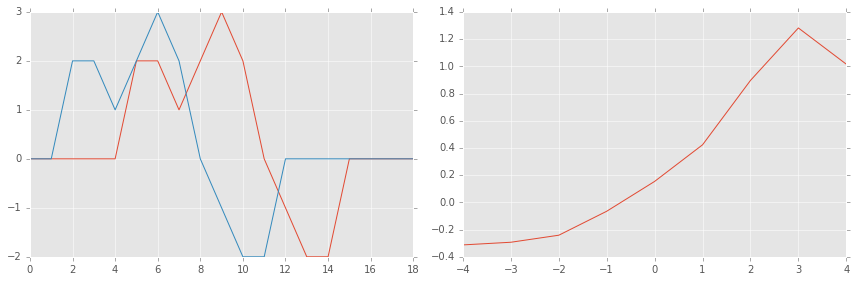

In [9]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(simple_a)
axes[0].plot(simple_b)
axes[1].plot(simple_lags, sliding_xcorr(simple_a, simple_b, simple_lags))
plt.tight_layout()

### Test on more realistic simulated data.

Time series from a random ARMA model, shifted by 7 frames.

In [10]:
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arma_generate_sample(ar, ma, 143)
z = sm.tsa.arma_generate_sample(ar, ma, 143)
arma_a = np.append(z[-7:], y)
arma_b = np.append(y, z[0:7])

Maximum cross-correlation exists at a lag of 7.


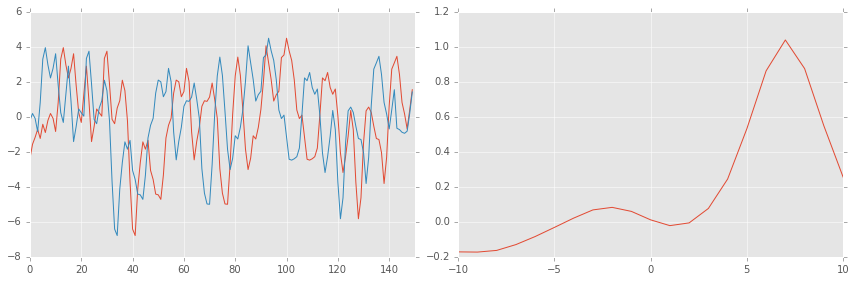

In [11]:
arma_lags = range(-10, 11)
arma_xcorr =  sliding_xcorr(arma_a, arma_b, arma_lags)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(arma_a)
axes[0].set_xlim(0,len(arma_a))
axes[0].plot(arma_b)
axes[1].plot(arma_lags, arma_xcorr)
plt.tight_layout()
report_xcorr(arma_xcorr, arma_lags)

### Test with aliased sampling and parabolic interpolation.

Using the same data as above, but with an aliased sampling window with a width of 2 frames.

In [12]:
arma_a_aliased = np.mean(np.reshape(arma_a, (-1, 3)), axis=1)
arma_b_aliased = np.mean(np.reshape(arma_b, (-1, 3)), axis=1)

Maximum cross-correlation exists at a lag of 2.25223646899.


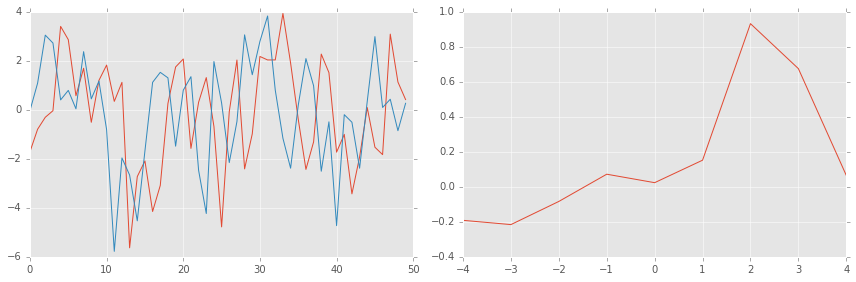

In [13]:
arma_lags_aliased = range(-4, 5)
arma_aliased_xcorr =  sliding_xcorr(arma_a_aliased, arma_b_aliased, arma_lags_aliased)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(arma_a_aliased)
axes[0].set_xlim(0,len(arma_a_aliased))
axes[0].plot(arma_b_aliased)
axes[1].plot(arma_lags_aliased, arma_aliased_xcorr)
plt.tight_layout()
report_xcorr(arma_aliased_xcorr, arma_lags_aliased, interp=True)

## Test on Real Data

In [14]:
# Set input data paths.
epi_minimal_path = '/home/despo/dlurie/Projects/megarest_lag/data/sub101/Aifo/sub101_Aifo_rest_1_minimal.nii.gz'
epi_compcor_path = '/home/despo/dlurie/Projects/megarest_lag/data/sub101/Aifo/sub101_Aifo_rest_1_compcor.nii.gz'
epi_compcor_gsr_path = '/home/despo/dlurie/Projects/megarest_lag/data/sub101/Aifo/sub101_Aifo_rest_1_compcor_gsr.nii.gz'
gm_seg_path = '/home/despo/dlurie/Projects/megarest_lag/data/sub101/sub101_gm_seg.nii'

In [15]:
# Load the EPI images.
epi_minimal_img = nib.load(epi_minimal_path)
epi_compcor_img = nib.load(epi_compcor_path)
epi_compcor_gsr_img = nib.load(epi_compcor_gsr_path)

In [16]:
# Load the gray matter segmentation.
gm_seg_img = nib.load(gm_seg_path)
# Resample the segmentation to match the minimal EPI (which will be our reference image for the next few steps).
gm_seg_resampled_img = image.resample_to_img(gm_seg_img, epi_minimal_img)
# Create a 30% mask from the resampled segmentation.
gm_mask_resampled_img = image.math_img('(img1 > .30).astype(bool)', img1=gm_seg_resampled_img)

In [18]:
epi_minimal_mean_img = image.mean_img(epi_minimal_img)

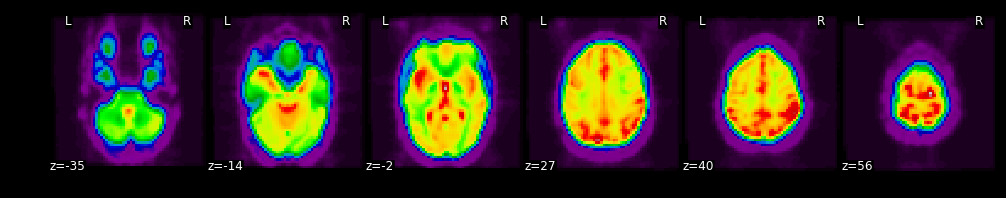

In [19]:
plotting.plot_epi(epi_minimal_mean_img, display_mode='z',
                  cut_coords=[-35, -14, -2, 27, 40, 56])

In [20]:
masker = NiftiMasker(mask_strategy='epi')
masker.fit(epi_minimal_img)
epi_brain_mask_img = masker.mask_img_

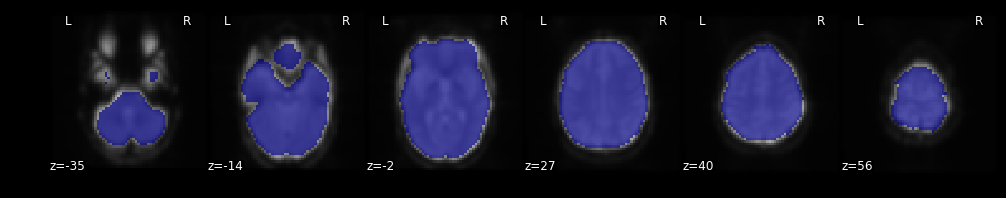

In [21]:
plotting.plot_roi(epi_brain_mask_img, epi_minimal_mean_img, display_mode='z',
                  cut_coords=[-35, -14, -2, 27, 40, 56], dim=-.45)

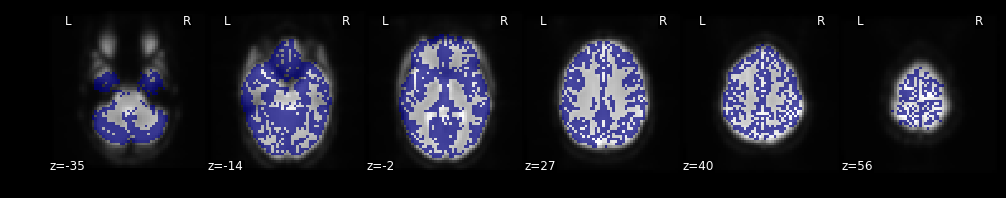

In [22]:
plotting.plot_roi(gm_mask_resampled_img, epi_minimal_mean_img, display_mode='z',
                  cut_coords=[-35, -14, -2, 27, 40, 56], dim=-.45)

In [23]:
gm_brain_mask_intersect_img = masking.intersect_masks([gm_mask_resampled_img, epi_brain_mask_img])

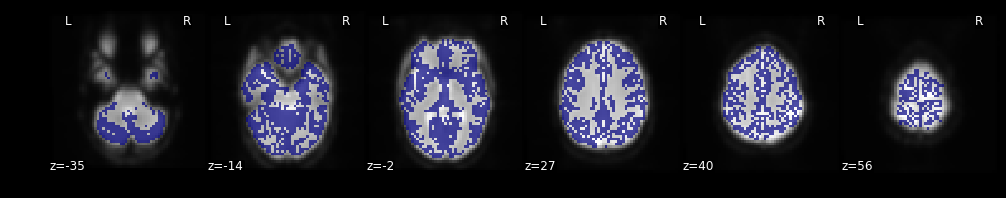

In [25]:
plotting.plot_roi(gm_brain_mask_intersect_img, epi_minimal_mean_img, display_mode='z',
                  cut_coords=[-35, -14, -2, 27, 40, 56], dim=-.45)

In [31]:
epi_minimal_gm_masked_data = masking.apply_mask(epi_minimal_img, gm_brain_mask_intersect_img)
epi_minimal_brain_masked_data = masking.apply_mask(epi_minimal_img, epi_brain_mask_img)

epi_compcor_gm_masked_data = masking.apply_mask(epi_compcor_img, gm_brain_mask_intersect_img)
epi_compcor_brain_masked_data = masking.apply_mask(epi_compcor_img, epi_brain_mask_img)

epi_compcor_gsr_gm_masked_data = masking.apply_mask(epi_compcor_gsr_img, gm_brain_mask_intersect_img)
epi_compcor_gsr_brain_masked_data = masking.apply_mask(epi_compcor_gsr_img, epi_brain_mask_img)

In [28]:
np.std(epi_minimal_brain_masked_data, axis=0).min()

1.8566353

In [29]:
np.std(epi_minimal_gm_masked_data, axis=0).min()

1.8566353

In [88]:
TR = 2
epi_minimal_mean_signal = TimeSeries(np.mean(epi_minimal_brain_masked_data, axis=1), sampling_interval=TR)
epi_compcor_mean_signal = TimeSeries(np.mean(epi_compcor_brain_masked_data, axis=1), sampling_interval=TR)
epi_compcor_gsr_mean_signal = TimeSeries(np.mean(epi_compcor_gsr_brain_masked_data, axis=1), sampling_interval=TR)

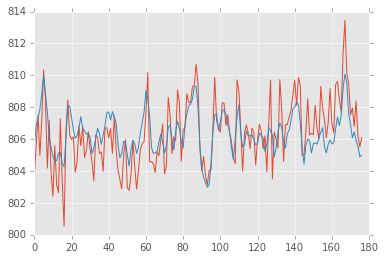

In [105]:
F = FilterAnalyzer(epi_minimal_mean_signal, ub=0.1, lb=0.01)

# Initialize a figure to display the results:
fig02 = plt.figure()
ax02 = fig02.add_subplot(1, 1, 1)

# Plot the original, unfiltered data:
ax02.plot(F.data, label='unfiltered')
ax02.plot(F.filtered_boxcar.data, label='Boxcar')

In [123]:
def plot_signal(TR, ub, lb, time_series):
    s_data = SpectralAnalyzer(time_series)
    f_data = FilterAnalyzer(time_series, ub=0.1, lb=0.01)
    s_filtered = SpectralAnalyzer(f_data.filtered_boxcar)
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(s_data.spectrum_multi_taper[0],s_data.spectrum_multi_taper[1], label='original')
    axes[0].plot(s_filtered.spectrum_multi_taper[0],s_filtered.spectrum_multi_taper[1], label='filtered')
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Power')
    axes[1].plot(time_series.data, label='original')
    axes[1].plot(f_data.filtered_boxcar.data, label='filtered')
    axes[1].set_xlabel('TR')
    axes[1].set_ylabel('Voxel intensity')
    plt.legend()
    plt.tight_layout()

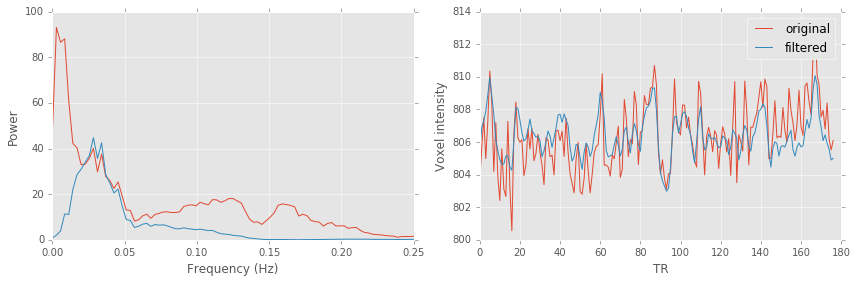

In [124]:
plot_signal(TR, 0.1, 0.01, epi_minimal_mean_signal)

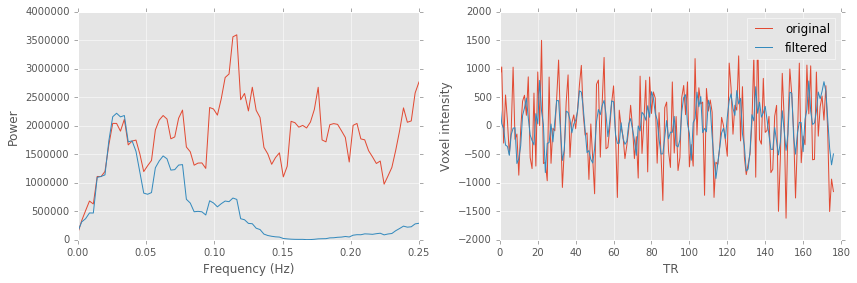

In [125]:
plot_signal(TR, 0.1, 0.01, epi_compcor_mean_signal)

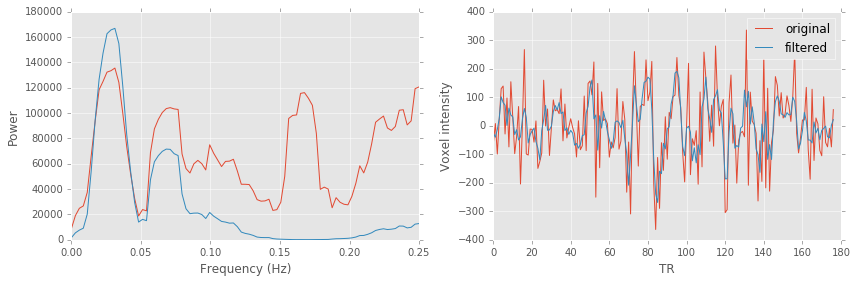

In [128]:
plot_signal(TR, 0.1, 0.01, epi_compcor_gsr_mean_signal)

In [ ]:
lags_4 = range(-4, 5)
lags_6 = range(-6, 7)
lags_8 = range(-8, 9)
lags_20 = range(-20, 21)

In [ ]:
@interact(voxel_select=widgets.IntSlider(min=0, max=5000), lags=fixed(lags_20))
def xcorr_viewer(voxel_select, lags):
    # Calculate and plot cross-correlation for the selected voxel.
    test_xcorr = sliding_xcorr(epi_brain_masked_data[:,voxel_select], np.mean(epi_gm_masked_data, axis=1), lags)
    plt.plot(lags, test_xcorr)
    # Calculate and report numerical maxima.
    num_maxima_idx = np.argwhere(test_xcorr == np.max(test_xcorr)).flatten()
    num_maxima_lags = list([lags[i] for i in num_maxima_idx])
    print("Lag(s) at numerical maxima: "+str(num_maxima_lags))
    # Calculate and report relative maxima (peaks)
    rel_maxima_idx = np.array(signal.argrelmax(np.array(test_xcorr))[0])
    if len(rel_maxima_idx) >= 1:
        rel_maxima_lags = [lags[i] for i in rel_maxima_idx]
        print("Lag(s) at relative maxima (peaks): "+str(rel_maxima_lags))
        rel_maxima_vals = [test_xcorr[i] for i in rel_maxima_idx]
        highest_peak_maxima_idx = np.argmax(rel_maxima_vals)
        print("Lag at highest peak: "+str(rel_maxima_lags[highest_peak_maxima_idx]))
        highest_peak_xcorr_idx = rel_maxima_idx[highest_peak_maxima_idx]
        lag_shift = np.sum(np.array(lags) > 0)
        print("Vertex of parabolic fit to highest peak: "+str(parabolic(test_xcorr, highest_peak_xcorr_idx)[0]-lag_shift))
    else:
        print("Relative maxima: None")

In [ ]:
def gen_lag_map(epi_img, brain_mask_img, gm_mask_img, lags):
    epi_gm_masked = masking.apply_mask()
    signal_a = np.mean(epi_gm_masked, axis=0)
    epi_brain_masked = epi_img[brain_mask_img]
    lag_index_correction = np.sum(np.array(lags) > 0)
    xcorr_array = []
    for voxel in epi_brain_masked:
    #for i, voxel in enumerate(epi_brain_masked):
        #print(i)
        signal_b = voxel
        vox_xcorr = sliding_xcorr(signal_a, signal_b, lags)
        xcorr_maxima = signal.argrelmax(np.array(vox_xcorr), order=1)[0]
        if len(xcorr_maxima) == 0:
            interp_max = np.argmax(vox_xcorr) - lag_index_correction
        elif len(xcorr_maxima) == 1:
            interp_max = parabolic(vox_xcorr, xcorr_maxima[0])[0]
            interp_max = interp_max - lag_index_correction
        elif len(xcorr_maxima) > 1:
            xpeak = xcorr_maxima[np.argmax(vox_xcorr[xcorr_maxima])]
            interp_max = parabolic(vox_xcorr, xpeak)[0]
            interp_max = interp_max - lag_index_correction
        xcorr_array.append(interp_max)
    return(np.array(xcorr_array))

In [ ]:
numpy.seterr(all='warn')

In [ ]:
rest1_lag_map_data = gen_lag_map(rest1_epi_data_resampled, brain_mask_data, gm_mask_data, lags_4)

In [ ]:
rest1_lag_map_data = gen_lag_map(rest1_epi_data_resampled, epi_auto_mask.get_data().astype(bool), gm_mask_union_img.get_data().astype(bool), lags_4)

In [ ]:
rest1_lag_map_image = masking.unmask(rest1_lag_map_data, brain_mask_img)

In [ ]:
nib.save(rest1_lag_map_image, '/home/despo/dlurie/Projects/lag_maps/test_data/megarest/sub101/101_rest1_lag_map.nii.gz')

In [ ]:
rest1_lag_map_image_smoothed5 = image.smooth_img(rest1_lag_map_image, 5)

In [ ]:
nib.save(rest1_lag_map_image_smoothed5, '/home/despo/dlurie/Projects/lag_maps/test_data/megarest/sub101/101_rest1_lag_map_smoothed5.nii.gz')

In [ ]:
unmasked_data = np.zeros(brain_mask_data.shape, dtype=test_out.dtype)
unmasked_data[brain_mask_data] = test_out

In [ ]:
a = np.ma.masked_where(unmasked_data == 0, unmasked_data)

In [ ]:
cwb = plt.cm.coolwarm
cwb.set_bad(color='black')

In [ ]:
#slice_slider = IntSlider
# decorate the plot function with an environment from the UIs:
@interact(slice_select=widgets.IntSlider(min=0, max=37, step1=1, value=15))
def slice_viewer(slice_select):
    plt.imshow(a.T[slice_select,:,:], cmap=cwb, vmin=-4, vmax=4, interpolation='none')
    plt.colorbar()

In [ ]:
range(101,115)+[116]+range(118,130)